<a href="https://colab.research.google.com/github/avipreet21/cap-comp215/blob/main/Finalproject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# FINAL PROJECT
Name - Avipreet Singh

Date - 2023-04-11

## Simple sugarscape model

In 1996 Joshua Epstein and Robert Axtell proposed Sugarscape, an agent-based model of an “artificial society” intended to support experiments related to economics and other social sciences.
This version of Sugarscape is often used to explore and explain the distribution of wealth, in particular the tendency toward inequality.

## Modules

In [1]:
%matplotlib inline

import time

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import animation
from scipy.signal import correlate2d
import random
import time
import pprint
from scipy.spatial import distance
import timeit
# get the current time as a seed for the random number generator
random.seed(time.time())
# Configure matplotlib's animation library to work in the browser.
matplotlib.rc('animation', html='jshtml')

In [2]:
pip install empiricaldist

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for empiricaldist: filename=empiricaldist-0.6.8-py3-none-any.whl size=12122 sha256=1b2acff58b77b27b1749ae1d6bc2415dbb0cda6799ec48455bdc3f21b9b28a0a
  Stored in directory: /root/.cache/pip/wheels/ba/30/d8/653166652404970cf48ec032ff1e90784bb804739d1834fc01
Successfully built empiricaldist


In [3]:
from empiricaldist import Cdf

## Helpers
Some useful, re-usable bits of code developed in labs notebooks...

In [4]:
DEFAULT_IMSHOW_OPTIONS = dict(
    cmap='Blues',
    interpolation='none',
    origin='upper',
)


def plot_2D_array(array, axes=None, title='', **options):
    """ Plot the 2D array as an image on the given axes  1's will be dark blue, 0's will be light blue. """
    axes = axes or plt.gca()  # If not axes are provided, draw on current axes
    axes.set_title(title)
    axes.set_xticks([], [])  # remove axes tick marks
    axes.set_yticks([], [])
    options = {**DEFAULT_IMSHOW_OPTIONS, **options}
    axes.imshow(array, **options)

In [5]:
class Animation2D:
    """
      Animates any 2D model with a step() method and a draw() method, using matplotlib
      model.step() should take no parameters - just step the model forward one step.
      model.draw() should take 2 parameters, the matpltolib axes to draw on and an integer step number

      See https://www.allendowney.com/blog/2019/07/25/matplotlib-animation-in-jupyter/
          for a discussion of the pros and cons of various animation techniques in jupyter notebooks
    """

    def __init__(self, model, frames=50, steps_per_frame=1, figsize=(8, 8)):
        """
        :param model: the simulation object to animate, with step() and draw(axes, step) methods
        :param frames: number of animation frames to generate
        """
        self.model = model
        self.frames = frames
        self.steps_per_frame = steps_per_frame
        self.fig, self.ax = plt.subplots(figsize=figsize)

    def animation_step(self, step):
        """ Step the model forward and draw the plot """
        if step > 0:
            for _ in range(self.steps_per_frame):
                self.model.step()
        self.model.draw(self.ax, step=step * self.steps_per_frame)

    def show(self):
        """ return the matplotlib animation object, ready for display """
        anim = animation.FuncAnimation(self.fig, self.animation_step, frames=self.frames)
        plt.close()  # this ensures the last frame is not shown as a separate plot
        return anim

    def animate(self, interval=None):
        """ Animate the model simulation directly in the notebook display block """
        from IPython.display import clear_output
        try:
            for i in range(self.frames):
                clear_output(wait=True)  # clear the IPython display
                self.ax.clear()  # clear old image from the axes (fixes a performance issue)
                plt.figure(self.fig)  # add the figure back to pyplot ** sigh **
                self.animation_step(i)
                plt.show()  # show the current animation frame (pyplot then closes and throws away figure ** sigh **)
                if interval:
                    time.sleep(interval)
        except KeyboardInterrupt:
            pass

## Functions used
In the Sugarscape grid, each cell has a capacity, which is the maximum amount of sugar it can hold. In the original configuration, there are two high-sugar regions, with capacity 4, surrounded by concentric rings with capacities 3, 2, and 1.function that are used in the model to made this possible...

---
### Function distances_from

The function distances_from takes in three arguments n, i, and j representing the size of an array and the coordinates (i, j) to compute distances from. It returns an array of floats representing the Euclidean distances from (i, j) to each point in the array.

The implementation uses the NumPy indices function to generate two array, X and Y, representing the x and y coordinates of each point in the array. It then uses the NumPy hypot function to compute the Euclidean distance between each point in the array and (i, j).

### Funcion assign_capacity

The assign_capacity function takes in two arguments: capacities, which is a list of values to assign to the concentric rings surrounding the center; and dist_array comes from the function distance_from which contains the distances of each element from center.


In summary, the assign_capacity function uses the distance_from function to compute the distances from the center point to each point, and assigns values from the capacities list to the concentric rings surrounding the center based on the sorted distances.

In [6]:
def distances_from(n, i, j):
    """Computes an array of distances.
    
    n: size of the array
    i, j: coordinates to find distance from
    
    returns: array of float
    """
    X, Y = np.indices((n, n))
    return np.hypot(X-i, Y-j)

def assign_capacity(dist_array,capacities):
  return np.digitize(dist_array, capacities)


## Sugarscape model

In its simplest form, Sugarscape is a model of a simple economy where agents move around on a 2-D grid, harvesting and accumulating “sugar”, which represents economic wealth. Some parts of the grid produce more sugar than others, and some agents are better at finding it than others.

---



Rules

The agent surveyS k cells in each of the 4 compass directions, where k is the range of the agent’s vision.

It chooses the unoccupied cell with the most sugar. In case of a tie, it chooses the closer cell; among cells at the same distance, it chooses randomly.

The agent moves to the selected cell and harvests the sugar, adding the harvest to its accumulated wealth and leaving the cell empty.

The agent consumes some part of its wealth, depending on its metabolism. If the resulting total is negative, the agent “starves” and is removed.

After all agents have executed these steps, the cells grow back some sugar, typically 1 unit, but the total sugar in each cell is bounded by its capacity.

In [13]:
class Sugarscape:

    def __init__(self, size, num_agents):
        self.size = size  # size of the state
        self.num_agents = num_agents
        self.agents = []  # This list contains all the agents.
        self.capacity = self.create_capacity()  # calling the function to create the capacities in the state.
        self.state = self.capacity.copy()
        self.init_agents()  # calling the function init agents to create the agents at random positions.

    def create_capacity(self):
        """Creating two capacities around the whole state in two different corners."""

        """Compute the distance of each cell from the peaks."""
        """These peaks are chosen so that they set according to the size of the state."""

        dist_peak1 = distances_from(self.size, int(self.size / 3), int(self.size / 3))  # first peak at (size/3, size/3) coordinate.
        dist_peak2 = distances_from(self.size, 2 * int(self.size / 3), 2 * int(self.size / 3))  # second peak at (2 * size/3, 2 * size/3) coordinate.

        mini_dist = np.minimum(dist_peak1, dist_peak2)  # choosing the minimum distance from the both peaks so that they won't overlap.

        """If one cell is 3 units away from one peak and 2 units from the other, np.minimum will assign 2 to that cell."""

        # Cells in the capacity array are set according to distance from peak.
        capacities = [21, 16, 11, 6]  # values to assign.
        capacity_array = assign_capacity(mini_dist, capacities)

        return capacity_array

    def init_agents(self):
        for i in range(self.num_agents): 
            pos = (random.randint(0, self.size - 1), random.randint(0, self.size - 1))  # random position
            sugar = np.random.randint(5, 26) # random sugar level between 5 and 26
            metabolism = np.random.randint(1, 5) # random metabolism for the agent between 1 and 5
            vision = np.random.randint(1, 7) # random vision for the agent between 1 and 5
            #adding the agent to the list self.agents.
            self.agents.append(Agent(pos, sugar, metabolism, vision)) # creating the agent with all the random attributes

    def step(self):
      '''Executes one time step of the simulation.'''
      for agent in self.agents:
        '''looping through each agent'''
        # Get the cell with the most sugar within the agent's vision range
        new_pos = agent.look_for_sugar(self.state) 

        # Add the sugar in the current cell to the agent's sugar level
        agent.add_sugar(self.state, new_pos)

        # Set the sugar level of the cell where the agent found the sugar to zero
        self.state[new_pos] = 0

        # Consume energy(some of the agent's sugar level)based on its metabolism rate
        agent.consume()

        # Update the agent's location to the location of the cell where it found the sugar
        agent.location = new_pos

        # If the agent's sugar level is less than or equal to zero, remove it from the list of agents(agent is dead).
        if agent.sugar_level <= 0:
            self.agents.remove(agent)


        '''Sugar regrowth'''
        # Regrow the sugar on the Sugarscape by incrementing the sugar level of each cell by one, bounded by its capacity.
        new_state = np.minimum(self.state + 1, self.create_capacity())

        self.state = new_state

    def alive_agents(self):
      '''Returns a list of the vision ranges of all agents.'''
      return len(self.agents)

    def get_vision(self):
      '''Returns a list of the vision ranges of all agents.'''
      return [agent.vision for agent in self.agents]

    def get_metabolism(self):
      '''Returns a list of the metabolism of all agents.'''
      return [agent.metabolism for agent in self.agents]

    def average_vision(self):
      '''Returns a average vision range of all alive agents.'''
      return round(np.sum(self.get_vision())/len(self.get_vision()),2)

    def average_metabolism(self):
      '''Returns a average metabolism of all alive agents.'''
      return round(np.sum(self.get_metabolism())/len(self.get_metabolism()),2)

    def draw(self, axes, step):
      '''Visualizes the current state of the Sugarscape object and the positions of all agents on a matplotlib axes object.'''
      axes.set_title(f"Step {step}, agents {self.alive_agents()}")
      axes.imshow(self.state, cmap='YlOrRd', vmax=9, origin='lower')
      for agent in self.agents:
          x, y = agent.location
          axes.scatter(y + 0.5, x + 0.5, color='r', alpha=0.6)
      axes.set_xticks([])
      axes.set_yticks([])
      axes.set_xlim([0, self.state.shape[1]])
      axes.set_ylim([0, self.state.shape[0]])


## Agent

Sugar_level: Each agent starts with an endowment of sugar chosen from a uniform distribution between 5 and 25 units.

Metabolism: Each agent has some amount of sugar they must consume per time step, chosen uniformly between 1 and 4.

Vision: Each agent can “see” the amount of sugar in nearby cells and move to the cell with the most, but some agents can see and move farther than others. The distance agents see is chosen uniformly between 1 and 6.

In [8]:
class Agent:

  def __init__(self,location,sugar_level,metabolism,vision):
    self.location = location 
    self.sugar_level = sugar_level
    self.metabolism = metabolism
    self.vision = vision
    
  def look_for_sugar(self, state):
    old_x, old_y = self.location

    # Get the sub-array of nearby cells of agent which it can see.
    sub_array = state[
        max(old_x - self.vision, 0):min(old_x + self.vision + 1, state.shape[0]),
        max(old_y - self.vision, 0):min(old_y + self.vision + 1, state.shape[1])
    ]

    # Check if there is any sugar nearby
    if np.sum(sub_array) == 0:
        return old_x, old_y

    # Get the index of the cell which contains the maximum level of sugar
    max_indices = np.argwhere(sub_array == np.max(sub_array))

    # Handle ties by selecting one of the max indices randomly
    max_index = tuple(max_indices[np.random.choice(max_indices.shape[0])])
    
    # Get the coordinates of the selected cell within the sub-array
    new_subx, new_suby = max_index

    # Translate the coordinates of the selected cell to the coordinates in the full array
    new_pos = tuple((new_subx + old_x - self.vision, new_suby + old_y - self.vision))

    return new_pos
  
  def add_sugar(self,state, new_pos):
      '''Increases the sugar level of the agent by the amount of sugar in the cell it moves to.'''
      self.sugar_level = self.sugar_level + state[new_pos]
      
  def consume(self):
      '''Decreases the sugar level of the agent by its metabolism rate.'''
      self.sugar_level = self.sugar_level - self.metabolism

## Animation of the model

In [9]:
m1 = Sugarscape(50, 400)
#Animation2D(m1, frames=200).animate(interval=0.01)


##visualizing simulation

### Model Observation
The observation that most agents are moving towards areas with the most sugar can be explained by the natural tendency of agents to seek out resources that are necessary for their survival. In this case, sugar is a vital resource that the agents need to consume in order to sustain themselves.

The agents in this scenario are programmed to move towards areas with high concentrations of sugar, as this is where they are most likely to find enough food to survive. This behavior is similar to the way that animals in the wild search for food, as they are constantly seeking out the most abundant sources of resources.

As the agents move towards the areas with the most sugar, they are also able to consume more food and grow stronger. This allows them to better compete for resources with other agents, as well as to explore and exploit new areas where sugar may be found.

However, it is important to note that not all agents may be equally successful in finding sugar. Some agents may have better vision or be better at navigating the environment, while others may be less successful. Additionally, agents that are born in areas with low concentrations of sugar may struggle to find enough food to survive, even if they are able to move towards the areas with the most sugar.

Overall, the movement of the agents towards areas with high concentrations of sugar is a natural and necessary behavior that allows them to find the resources they need to survive and compete in their environment.

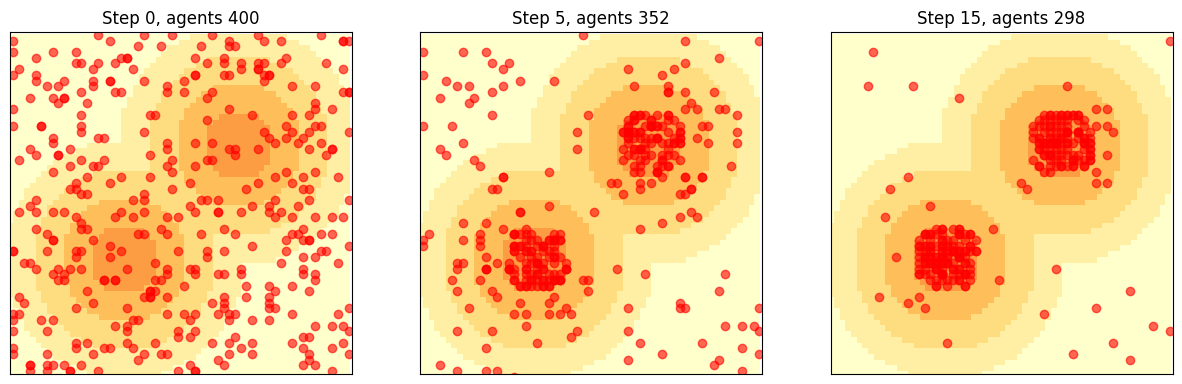

In [14]:
m2 = Sugarscape(60, 400)

# Only draw at specified time steps
draw_times = [0, 5, 15]
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
axes = [ax1, ax2, ax3]

# Perform steps and draw at specified times
for i in range(16):
  if i in draw_times:
    m2.draw(axes[draw_times.index(i)], i)
  m2.step()

### Agent observation
In this scenario, there are multiple agents moving around a space looking for sugar. The agents with high vision are able to move quickly towards areas with high concentrations of sugar, while those with low vision tend to get stuck on plateaus and have to wander randomly until they can see the next level.

Agents born in areas with low concentrations of sugar are at a disadvantage and may struggle to find enough food to survive, unless they have a high initial endowment (i.e. they start with a lot of resources) and high vision.

Overall, the ability to locate and harvest sugar is critical for the survival of these agents. Those with high vision and/or initial endowments are more likely to succeed, while those with low vision or high metabolic rates may struggle to survive in the long term.

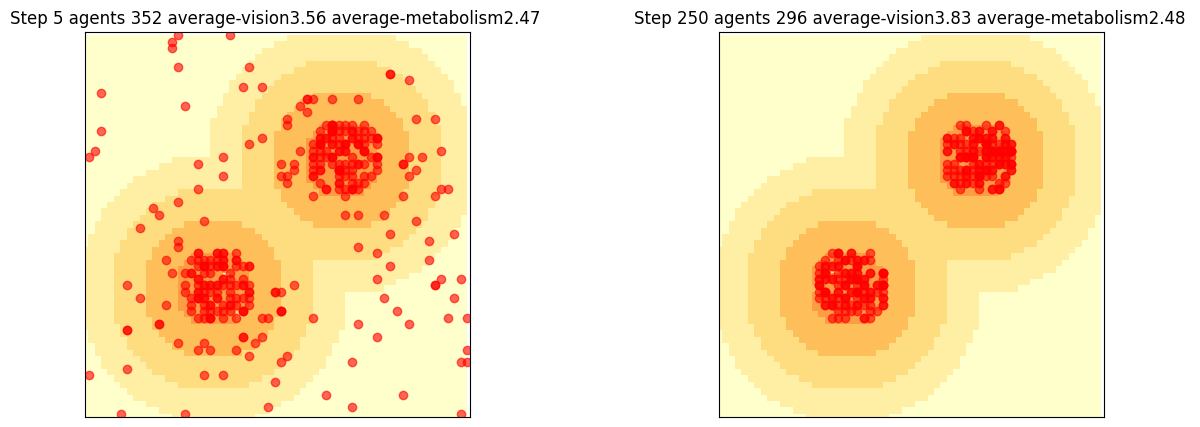

In [15]:
m3 = Sugarscape(60, 400)

# Only draw at specified time steps
draw_times = [5,250]
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
axes = [ax1, ax2, ax3]

# Perform steps and draw at specified times
for i in range(255):
  if i in draw_times:
    m3.draw(axes[draw_times.index(i)], i)
    axes[draw_times.index(i)].set_title(f"Step {i} agents {m3.alive_agents()} average-vision{m3.average_vision()} average-metabolism{m3.average_metabolism()} ")
  m3.step()

###Steady state
state of the model after 100 time steps, with about 280 agents. The agents who survive tend to be the lucky ones, born with high vision and/or low metabolism. Having survived to this point, they are likely to survive forever, accumulating unbounded stockpiles of sugar



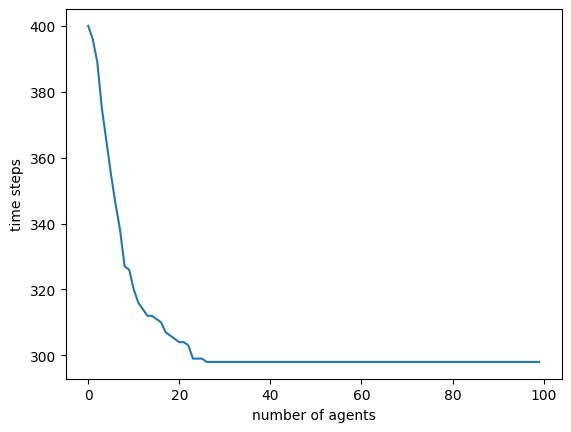

In [16]:
m4 = Sugarscape(60, 400)
x= []
y= []
for i in range(100):
  m4.step()
  x.append(i)
  y.append(m4.alive_agents())

plt.plot(x,y)
plt.xlabel("number of agents")
plt.ylabel("time steps")
plt.show()